<a href="https://colab.research.google.com/github/ramkumarr02/Titanic-Prediction-using-Pytorch/blob/master/Titanic_Pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Env Setup

## Packages



In [0]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

from sklearn.utils import shuffle
#from torch.autograd import Variable

import matplotlib.pyplot as plt 

import warnings
warnings.filterwarnings("ignore")

## Mount Drive


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Functions

## Split Columns

In [0]:
def column_split(df):

    try:
        df['SurName'], df['Name'] = df['Name'].str.split(',', 1).str
        df['Title'], df['Name'] = df['Name'].str.split('.', 1).str
        df['Cabin_Section'] = df[df['Cabin'].notna()]['Cabin'].astype(str).str[0]
        df['Cabin_Nums'] = df[df['Cabin'].notna()]['Cabin'].str.count(" ") + 1
        del df['Name']
        del df['Ticket']
        del df['Cabin']
        #del df['SurName']
        
    except:
        pass
    
    return(df)

## Impute Age by title

In [0]:
def impute_age_by_title(df):       
    train_with_age = df.copy()

    train_with_age_notnull = train_with_age[train_with_age['Age'].notna()]

    age_map = train_with_age_notnull.groupby(['Title'])['Age'].mean().astype('int').to_dict()
    age_map[' Ms'] = 28

    #temp = train_with_age['Age']

    for i, row in train_with_age.iterrows():           
        if pd.isnull(row['Age']):
            df.Age[i] = age_map[train_with_age.Title[i]]  

    return(df)

## Change all data type into int

In [0]:
def change_dtype(df):
    not_int_cols = list(df.select_dtypes(exclude=['int']).columns)
    df[not_int_cols] = df[not_int_cols].astype('int')
    return(df)

## Scale Data

In [0]:
def scale_data(df):

    scaled_features = StandardScaler().fit_transform(df.values)
    df = pd.DataFrame(scaled_features, index=df.index, columns=df.columns)
 
    return(df)

## PreProcess Data

In [0]:
def pre_process(df, prep_flag = None, train_data = None):        

    # Feature Engineering : Split Columns
    df = column_split(df)

    # Feature Engineering : Impute Age by Title
    df = impute_age_by_title(df)

    # One Hot Encoding
    df = pd.get_dummies(df)

    if prep_flag != None:
        train_data, df = train_data.align(df, join='left', axis=1)

    # Remove NaN
    df = df.fillna(0)

    # Change all Data types to Int
    df = change_dtype(df)

    # Scale Data
    scaled_df = scale_data(df)

    return(scaled_df)

## PD.DF to Tensor.DF

In [0]:
def df2df_tens(x,y):
    tens_x = torch.FloatTensor(x.values.astype('float'))
    tens_y = torch.LongTensor(y.values.astype('long'))
    
    df_tens = TensorDataset(tens_x, tens_y)    

    return(df_tens)

In [0]:
def acc_loss_plot(loss_list, accuracy_list):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(loss_list,color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis = 'y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(accuracy_list, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped    
    plt.show()
    return()

## Net List

In [0]:
class Net(nn.Module):
    def __init__(self, layers, activation, p=0, weight_init = None):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        self.drop = nn.Dropout(p=p)
        for input_dim, output_dim in zip(layers, layers[1:]):
            linear = nn.Linear(input_dim, output_dim)
            if weight_init != None:
                weight_init(linear.weight)
            self.hidden.append(linear) 
    
    def forward(self, x):
        L = len(self.hidden)
        for l, linear_layer in zip(range(L), self.hidden):
            if l < L-1:                              
                x = linear_layer(x)                
                x = self.drop(x)
                x = activation(x)                
            else:
                x = linear_layer(x)
 
        return(x)

## Model Trainer

In [0]:
def train_model(num_epochs, optimizer, criterion, train_loader, valid_loader, n_test):
    loss_list = []
    accuracy_list = []  

    for epoch in range(num_epochs):   
        model.train()
        for x,y in train_loader:        
            optimizer.zero_grad()
            yhat = model(x)
            loss =criterion(yhat, y)
            loss.backward()
            optimizer.step()

        model.eval()
        correct = 0
        for x_test, y_test in valid_loader:        
            z = model(x_test)
            _, yhat = torch.max(z.data, 1)        
            correct += (yhat == y_test).sum().item()
        model.train()

        accuracy = correct/n_test        
        accuracy_list.append(accuracy)
        loss_list.append(loss.data)        

        if epoch % 2 == 0:
            print(f'Epoch : {epoch}, Loss : {loss.data} , Accuracy : {accuracy}')        

        if epoch == num_epochs-1:               
            acc_loss_plot(loss_list, accuracy_list)           

    return(model, loss_list, accuracy_list)

# Code Engine

## Read Data

In [12]:
train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Deep Learning/Titanic/PyTorch/train.csv')
test = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Deep Learning/Titanic/PyTorch/test.csv')

train_copy = train.copy()
test_copy = test.copy()

del train['PassengerId']
del test['PassengerId']

train.head(2)

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


## Split Data for OOB testing

In [0]:
train = pd.concat([train]*20, ignore_index=True)

In [0]:
train_x, valid_x, train_y, valid_y = train_test_split(train.loc[:, train.columns != 'Survived'], train['Survived'],train_size = 0.8,random_state = 1)

## PreProcess Data

In [0]:
temp_whole_df = train_x.append(test).reset_index(drop=True)
scaled_whole_df = pre_process(temp_whole_df)
ref_df = scaled_whole_df.copy()
#ref_df = scaled_train_x

In [0]:
#scaled_train_x = pre_process(train_x)
scaled_train_x = pre_process(train_x, train_data = ref_df, prep_flag = 'train')
scaled_valid_x = pre_process(valid_x, train_data = ref_df, prep_flag = 'valid')

In [0]:
# Convert Dataframe to Tensor Dataframe 
train_tensor = df2df_tens(scaled_train_x,train_y)
valid_tensor = df2df_tens(scaled_valid_x,valid_y)

In [0]:
# Data Loader : Train and valid
batch_size = 20
train_loader = DataLoader(dataset = train_tensor, batch_size=batch_size, shuffle = True)
valid_loader = DataLoader(dataset = valid_tensor, batch_size=batch_size, shuffle = True)

# Modelling

## Neural Net Parameters


In [0]:
input_size  = list(train_loader)[0][0].shape[1]
output_size = 2
layers = [input_size, 512, 128, 64, output_size]
activation = F.tanh     #activation = F.relu
p = 0.5                 #Dropout value
weight_init = torch.nn.init.xavier_uniform_

## Neural Net

In [0]:
model = Net(layers, activation, p, weight_init)

## Training Parameters

In [0]:
num_epochs  = 15
criterion = nn.CrossEntropyLoss()
train_loader = train_loader
valid_loader = valid_loader
n_test = len(scaled_valid_x)

learning_rate = 0.01
momentum=0.9

#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum = momentum)

## Training

Epoch : 0, Loss : 0.007299880031496286 , Accuracy : 0.9817620650953984
Epoch : 2, Loss : 0.008734609000384808 , Accuracy : 0.9896184062850729
Epoch : 4, Loss : 0.0012588934041559696 , Accuracy : 0.9915824915824916
Epoch : 6, Loss : 0.07727167010307312 , Accuracy : 0.9907407407407407
Epoch : 8, Loss : 0.0017058952944353223 , Accuracy : 0.9929854096520763
Epoch : 10, Loss : 0.0005269726389087737 , Accuracy : 0.9921436588103255
Epoch : 12, Loss : 0.04117745906114578 , Accuracy : 0.9929854096520763
Epoch : 14, Loss : 0.004000064451247454 , Accuracy : 0.9924242424242424


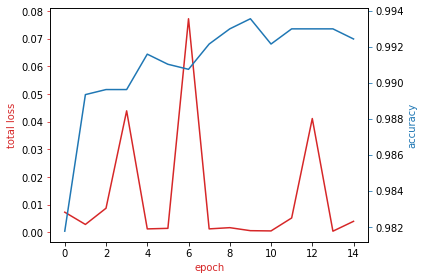

In [22]:
model, loss_list, accuracy_list = train_model(num_epochs, optimizer, criterion, train_loader, valid_loader, n_test)

# Testing

## Prep Test data

In [0]:
scaled_test_x = pre_process(test, train_data = ref_df, prep_flag = 'Test')
test_x_tens = torch.FloatTensor(scaled_test_x.values.astype('float'))

## Predict

In [24]:
z_test = model(test_x_tens)
_, yhat = torch.max(z_test.data, 1)
print(len(yhat))

418


In [0]:
test_copy['Survived'] = yhat
df_results = test_copy[['PassengerId', 'Survived']]
df_results.to_csv('results.csv', index = False)